In [44]:
from collections import Counter
import pandas as pd



def predict_holdout(pop):
    forest_predictions = []
    sample_sizes = []
    for ind_num, individual in enumerate(pop):
        func = toolbox.compile(expr=individual)
    #     print individual
        sample_counts = [int(func(*record)) for record in X_train]
        sample_counts = [max(min(sample_count, max_sample), 0) for sample_count in sample_counts]
        sample = []
        for sample_index, sample_count in enumerate(sample_counts):
            sample.extend([sample_index] * sample_count)
        sample = np.array(sample)
        
        if len(sample) == 0:
            continue
        
        sample_sizes.append(X_train[sample].shape[0])

        clf = base_estimator
        clf.fit(X_train[sample], y_train[sample])
        predictions = clf.predict(X_test_tot)
        forest_predictions.append(predictions)
    y_pred = np.array(
    [Counter(instance_forest_predictions).most_common(1)[0][0] for instance_forest_predictions in zip(*forest_predictions)])
    
    return np.sum(y_test_tot == y_pred)*1.0 / len(y_test_tot)

def predict_private_test(pop):
    forest_predictions = []
    sample_sizes = []
    for ind_num, individual in enumerate(pop):
        func = toolbox.compile(expr=individual)
    #     print individual
        sample_counts = [int(func(*record)) for record in X_train]
        sample_counts = [max(min(sample_count, max_sample), 0) for sample_count in sample_counts]
        sample = []
        for sample_index, sample_count in enumerate(sample_counts):
            sample.extend([sample_index] * sample_count)
        sample = np.array(sample)
        
        if len(sample) == 0:
            continue
        
        sample_sizes.append(X_train[sample].shape[0])

        clf = base_estimator
        clf.fit(X_train[sample], y_train[sample])
        predictions = clf.predict(X_test)
        forest_predictions.append(predictions)
    y_pred = np.array(
    [Counter(instance_forest_predictions).most_common(1)[0][0] for instance_forest_predictions in zip(*forest_predictions)])
    
    return np.sum(y_test == y_pred)*1.0 / len(y_test)

In [34]:
per_row_ease = {}


def update_per_row_ease(pop):
    forest_predictions = []
    sample_sizes = []
    for ind_num, individual in enumerate(pop):
        func = toolbox.compile(expr=individual)
    #     print individual
        sample_counts = [int(func(*record)) for record in X_train]
        sample_counts = [max(min(sample_count, max_sample), 0) for sample_count in sample_counts]
        sample = []
        for sample_index, sample_count in enumerate(sample_counts):
            sample.extend([sample_index] * sample_count)
        sample = np.array(sample)
        
        if len(sample) == 0:
            continue
        
        sample_sizes.append(X_train[sample].shape[0])

        clf = base_estimator
        clf.fit(X_train[sample], y_train[sample])
        predictions = clf.predict(X_test) #predict on internal test
        forest_predictions.append(predictions)
    
    df_pred = pd.DataFrame(forest_predictions)
    for ix, val in enumerate(y_test):
        true_value = val
        
        #number of individuals that got it right?
        correct_inds = (df_pred.iloc[:,ix] == true_value).sum()
        per_row_ease[ix] = correct_inds
    
    return

In [121]:
import operator
import itertools
import numpy as np

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.datasets import load_digits
from sklearn.cross_validation import train_test_split

from functools import partial

np.seterr(all='raise')

dataset = 'digit'

if dataset == 'digit':
    digits = load_digits()
    data_features, data_labels = digits.data, digits.target

if dataset == 'GAMETES':
    df = pd.read_csv('GAMETES-easy-4x2-way_her-0.4_pop-1600_attribs-100_discrete.csv', delimiter='\t')
    data_features, data_labels = df.iloc[:,:-1].values, df.iloc[:, -1].values

print data_features.shape



X_train_tot, X_test_tot, y_train_tot, y_test_tot = train_test_split(data_features, data_labels, stratify=data_labels,
                                                    train_size=0.75, test_size=0.25)


X_train, X_test, y_train, y_test = train_test_split(X_train_tot, y_train_tot, stratify=y_train_tot,
                                                    train_size=0.7, test_size=0.3)




# defined a new primitive set for strongly typed GP
pset = gp.PrimitiveSetTyped('MAIN', itertools.repeat(float, data_features.shape[1]), float, 'Feature')

# boolean operators
pset.addPrimitive(operator.and_, [bool, bool], bool)
pset.addPrimitive(operator.or_, [bool, bool], bool)
pset.addPrimitive(operator.not_, [bool], bool)

# floating point operators
# Define a protected division function
def protectedDiv(left, right):
    try: return left / right
    except (ZeroDivisionError, FloatingPointError): return 1.

pset.addPrimitive(operator.add, [float, float], float)
pset.addPrimitive(operator.sub, [float, float], float)
pset.addPrimitive(operator.mul, [float, float], float)
pset.addPrimitive(protectedDiv, [float, float], float)

# logic operators
# Define a new if-then-else function
def if_then_else(in1, output1, output2):
    if in1: return output1
    else: return output2

pset.addPrimitive(operator.lt, [float, float], bool)
pset.addPrimitive(operator.eq, [float, float], bool)
pset.addPrimitive(if_then_else, [bool, float, float], float)

# terminals
pset.addTerminal(False, bool)
pset.addTerminal(True, bool)
for val in np.arange(-10., 11.):
    pset.addTerminal(val, float)

creator.create('FitnessMax', base.Fitness, weights=(1.0,))
creator.create('Individual', gp.PrimitiveTree, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register('expr', gp.genHalfAndHalf, pset=pset, min_=1, max_=3)
toolbox.register('individual', tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)
toolbox.register('compile', gp.compile, pset=pset)


def _random_mutation_operator(individual, expr, pset):
    """Perform a replacement, insert, or shrink mutation on an individual
    Parameters
    ----------
    individual: DEAP individual
        A list of pipeline operators and model parameters that can be compiled by DEAP into a callable function
    Returns
    -------
    fitness: list
        Returns the individual with one of the mutations applied to it
    """
    mutation_techniques = [
        partial(gp.mutUniform, expr=expr, pset=pset),
        partial(gp.mutInsert, pset=pset),
        partial(gp.mutShrink)
    ]
    return np.random.choice(mutation_techniques)(individual)


def evaluate_individual(individual):
    global per_row_ease
    # Transform the tree expression into a callable function
    func = toolbox.compile(expr=individual)
    sample_counts = [int(func(*record)) for record in X_train]
    sample_counts = [max(min(sample_count, max_sample), 0) for sample_count in sample_counts]
    sample = []
    for sample_index, sample_count in enumerate(sample_counts):
        sample.extend([sample_index] * sample_count)
    sample = np.array(sample)
    
    if len(sample) == 0:
        return 1e-20,
    
    clf = base_estimator
    clf.fit(X_train[sample], y_train[sample])
    ypred = clf.predict(X_test)
    
    total_score = []
    
    for ix, pred_value in enumerate(ypred):
        true_value = y_test[ix]
        if  pred_value == true_value:
            scr = 1/float(per_row_ease[ix])
            total_score.append(scr)
        
    return sum(total_score),
    

toolbox.register('evaluate', evaluate_individual)
toolbox.register('select', tools.selTournament, tournsize=5)


toolbox.register('mate', gp.cxOnePoint)
toolbox.register('expr_mut', gp.genFull, min_=0, max_=3)
toolbox.register('mutate', _random_mutation_operator, expr=toolbox.expr_mut, pset=pset)


population = toolbox.population(n=100)
halloffame = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register('std', np.std)
stats.register('min', np.min)
stats.register('avg', np.mean)
stats.register('max', np.max)

clf = DecisionTreeClassifier(random_state=34092)
clf.fit(X_train_tot, y_train_tot)
print('Base DecisionTreeClassifier accuracy: {}'.format(clf.score(X_test_tot, y_test_tot)))

clf = RandomForestClassifier(random_state=34092)
clf.fit(X_train_tot, y_train_tot)
print('Base RandomForestClassifier accuracy: {}'.format(clf.score(X_test_tot, y_test_tot)))

clf = GradientBoostingClassifier(random_state=34092)
clf.fit(X_train_tot, y_train_tot)
print('Base GradientBoostingClassifier accuracy: {}'.format(clf.score(X_test_tot, y_test_tot)))

print('')

cxpb = 0.5
mutpb = 0.5
ngen = 20
verbose = True
max_sample = 50
holdout_perf = {}
base_estimator = DecisionTreeClassifier(random_state=34092)

logbook = tools.Logbook()
logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])


update_per_row_ease(population)

# Evaluate the individuals with an invalid fitness ~
invalid_ind = [ind for ind in population if not ind.fitness.valid]
fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
for ind, fit in zip(invalid_ind, fitnesses):
    ind.fitness.values = fit

if halloffame is not None:
    halloffame.update(population)

record = stats.compile(population) if stats else {}
logbook.record(gen=0, nevals=len(invalid_ind), **record)
if verbose:
    print(logbook.stream)

# Begin the generational process
for gen in range(1, ngen + 1):
    # Select the next generation individuals
    offspring = toolbox.select(population, len(population))

    # Vary the pool of individuals
    offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)

    # Evaluate the individuals with an invalid fitness
#     invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    invalid_ind = [ind for ind in offspring]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Update the hall of fame with the generated individuals
    if halloffame is not None:
        halloffame.update(offspring)

    # Replace the current population by the offspring
    population[:] = offspring

    update_per_row_ease(population)
        
    record = stats.compile(population) if stats else {}
    logbook.record(gen=gen, nevals=len(invalid_ind),**record)
    holdout_perf[gen] = predict_holdout(population)
    
    
    if verbose:
        print(logbook.stream)
#         print(fits.score.mean())
#         print(fits.contrib_variance.mean())
        print('Performance on hold-out set:', holdout_perf[gen])
        print(predict_private_test(population))
    
str(halloffame[0])


(1797, 64)
Base DecisionTreeClassifier accuracy: 0.853658536585
Base RandomForestClassifier accuracy: 0.940133037694
Base GradientBoostingClassifier accuracy: 0.973392461197

gen	nevals	std    	min  	avg 	max    
0  	100   	2.44728	1e-20	4.05	7.02946
1  	100   	1.73759	1e-20	5.71863	7.04146
('Performance on hold-out set:', 0.94235033259423506)
0.953086419753
2  	100   	1.13456	1e-20	4.30793	5.03266
('Performance on hold-out set:', 0.91796008869179602)
0.940740740741
3  	100   	0.967555	1e-20	4.26931	5.11199
('Performance on hold-out set:', 0.91130820399113077)
0.958024691358
4  	100   	1.16755 	1e-20	3.96886	5.38704
('Performance on hold-out set:', 0.8824833702882483)
0.925925925926
5  	100   	1.16093 	1e-20	4.13975	5.29145
('Performance on hold-out set:', 0.90465631929046564)
0.948148148148
6  	100   	0.894493	1e-20	4.28133	4.89749
('Performance on hold-out set:', 0.91796008869179602)
0.945679012346
7  	100   	0.755346	1e-20	4.13857	4.72862
('Performance on hold-out set:', 0.895787139

ZeroDivisionError: float division by zero

(array([ 1.,  2.,  1.,  3.,  8.,  6.,  5.,  4.,  9.,  6.]),
 array([ 23. ,  29.1,  35.2,  41.3,  47.4,  53.5,  59.6,  65.7,  71.8,
         77.9,  84. ]),
 <a list of 10 Patch objects>)

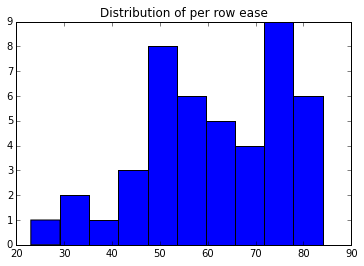

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.title('Distribution of per row ease')
plt.hist(list(per_row_ease.values()))
## row_mean_prob is the dictionary which holds per row true_p_variance.

Observation: Ideally, the graph should be as right skewed as possible. 


In [56]:
print("HOF Performance individually: ", predict_holdout([halloffame[0]]))
pop = offspring[:]
# pop = [halloffame[0]]


('HOF Performance individually: ', 0.44)


-------
Some statistics on the final population


In [4]:
pop = population
forest_predictions = []
subsample_sizes = []
for ind_num, individual in enumerate(pop):
    func = toolbox.compile(expr=individual)
#     print individual
    sample_counts = [int(func(*record)) for record in X_train]
    sample_counts = [max(min(sample_count, max_sample), 0) for sample_count in sample_counts]
    sample = []
    for sample_index, sample_count in enumerate(sample_counts):
        sample.extend([sample_index] * sample_count)
    sample = np.array(sample)
    
    if len(sample) == 0:
        continue
    
    subsample_sizes.append(len(sample))
    
    clf = DecisionTreeClassifier(random_state=34092)
    clf.fit(X_train[sample], y_train[sample])
    predictions = clf.predict(X_test_tot)
    forest_predictions.append(predictions)

In [12]:
import pandas as pd
# y_test_tot.shape
df

,0,1,2,3,4,5,6,7,8,9,...,441,442,443,444,445,446,447,448,449,450
0,9,8,5,6,5,3,1,9,1,2,...,5,9,0,0,1,1,2,0,2,6
1,9,7,5,1,6,3,2,5,1,2,...,4,3,8,0,1,1,0,0,8,0
2,1,4,5,1,4,7,8,5,1,4,...,4,3,8,0,1,1,4,0,8,0
3,9,7,5,7,5,8,2,3,1,2,...,4,3,0,0,1,1,9,0,8,0
4,9,7,5,1,5,8,2,9,1,2,...,5,3,9,0,7,1,0,0,8,0
5,9,7,2,8,6,9,2,9,1,8,...,0,8,8,0,1,1,0,0,8,0
6,9,7,5,1,6,2,2,5,1,2,...,4,3,9,0,1,1,0,0,8,0
7,9,7,5,5,6,2,9,5,1,2,...,4,3,9,0,1,1,0,0,8,0
8,9,9,5,1,6,3,7,5,1,2,...,4,3,8,0,1,1,0,0,8,0
9,1,8,5,1,6,2,1,5,1,2,...,4,2,2,0,7,8,0,0,8,0


In [10]:
from sklearn.metrics import accuracy_score

y_pred = np.array(
    [Counter(instance_forest_predictions).most_common(1)[0][0] for instance_forest_predictions in zip(*forest_predictions)])
np.sum(y_test_tot == y_pred)*1.0 / len(y_test_tot)

0.94678492239467849

In [11]:
# for x in 
import pandas as pd
fits = pd.DataFrame()
# fits['score'] = map(lambda x: x.fitness.values[0], pop)
fits['contrib_variance'] = [x.fitness.values[0] for x in pop]

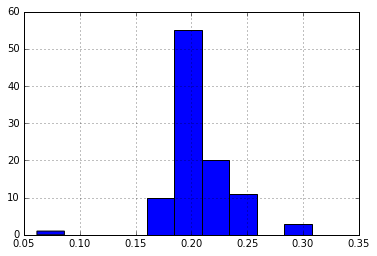

In [12]:
%matplotlib inline
fits.contrib_variance.hist()

3156.27
2329.66466194


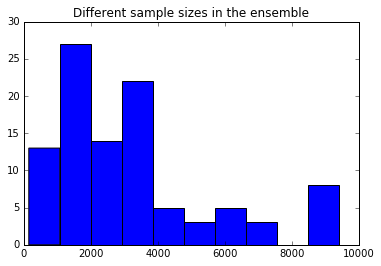

In [13]:
plt.title('Different sample sizes in the ensemble')
plt.hist(subsample_sizes)
print(np.mean(subsample_sizes))
print(np.std(subsample_sizes))


In [14]:

import pandas as pd
print("Mean # of unique labels predicted per sample by the ensemble.", pd.DataFrame(forest_predictions).apply(
    lambda x: len(x.unique()), axis=0).mean())

Mean # of unique labels predicted per sample by the ensemble. 5.35254988914


----

~ ~ ~ end of notebook - rough work follows ~ ~ ~

----

In [475]:
pd.DataFrame(forest_predictions)

,0,1,2,3,4,5,6,7,8,9,...,441,442,443,444,445,446,447,448,449,450
0,6,6,1,0,1,8,2,2,7,4,...,8,8,0,5,2,2,9,9,3,4
1,6,6,1,0,1,8,2,2,7,4,...,8,8,0,5,2,2,9,9,3,4
2,6,6,1,0,1,8,2,2,7,4,...,8,8,0,5,2,2,9,9,3,4
3,6,6,1,0,1,8,2,2,7,4,...,8,8,8,5,2,2,9,9,3,4
4,6,6,1,0,1,8,2,2,7,4,...,8,8,0,5,2,2,9,9,3,4
5,6,6,1,0,1,8,2,2,7,4,...,8,8,0,5,2,2,9,9,3,1
6,6,6,1,0,1,8,2,2,7,4,...,8,8,0,5,2,2,9,9,3,4
7,6,6,1,0,1,8,2,2,7,4,...,8,8,0,5,2,2,9,9,3,4
8,6,6,1,0,1,8,2,2,7,4,...,8,8,0,5,2,2,9,9,3,4
9,6,6,1,0,1,8,2,2,7,4,...,8,8,0,5,2,2,9,9,3,1


In [97]:
from sklearn import __version__

In [98]:
__version__

'0.17.1'

In [120]:
gg = selLexicase(population, 100)
gg

[[<deap.gp.Primitive at 0x13bffe40>,

[[<deap.gp.Primitive at 0x131b4810>,

In [117]:
len(np.unique(gg))

52

In [108]:
%matplotlib inline

(array([ 11.,  12.,  11.,   9.,   5.,   8.,  10.,   9.,   6.,  19.]),
 array([  3. ,  12.4,  21.8,  31.2,  40.6,  50. ,  59.4,  68.8,  78.2,
         87.6,  97. ]),
 <a list of 10 Patch objects>)

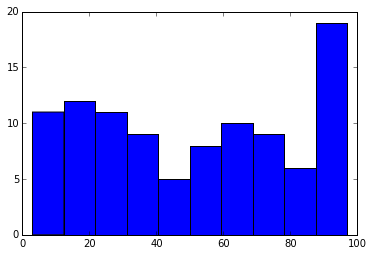

In [109]:
plt.hist(gg)